In [1]:
from qiskit import *
from qiskit import execute, BasicAer
from qiskit.quantum_info.synthesis import euler_angles_1q 
from qiskit.quantum_info.operators import Operator
from scipy.linalg import sqrtm 
from pyquil import *
from grove.alpha.arbitrary_state import arbitrary_state, unitary_operator
import numpy as np
import random
from sklearn.datasets import load_iris
from sklearn import preprocessing 
%matplotlib inline


class dist_classifier:
    def __init__(self):
        self.ancilla = QuantumRegister(1)
        self.index = QuantumRegister(1)
        self.encoding = QuantumRegister(1)
        self.label = QuantumRegister(1)
        self.measure = ClassicalRegister(2)
        self.classifier = QuantumCircuit(self.encoding, self.ancilla, self.index, self.label, self.measure)
        self.classifier.h(self.ancilla)
        self.classifier.h(self.index)
        self.classifier.barrier()


    def C2Ugate(self, vctr):
        matrix = unitary_operator.unitary_operator(vctr)
        m = self.create_control_gate(matrix, 2)
        self.classifier.unitary(m, [0,1,2], label = 'c2u')
        

    def da(self):
        dat = load_iris()  
        data = dat.data[:100, 2:]
        labels = dat.target[:100]

        #preprocessing:
        data = preprocessing.scale(data)
        data = preprocessing.normalize(data)
        #print(data)

#print(normalized_X)

        training_ind_X = random.sample(range(0,50), 2)
        training_ind_Y = random.sample(range(50,100), 2)
        xtrain = []
        ytrain = []

        for x in training_ind_X:
            xtrain.append(data[x])
        for x in training_ind_Y:
            ytrain.append(data[x])
        test_vctr = xtrain[1]
        print(xtrain)
        print(ytrain)
    
        return xtrain, ytrain, test_vctr
    
    def create_control_gate(self,U, num_control):
        print(U)
        l = 1
        num_tot = l + num_control
        CU = np.zeros((2**num_tot, 2**num_tot), dtype=complex)
        #print("CU: ", CU, "\nU:", U, "\n Num:", num_control, "\n Tot:", num_tot)
        ind = 2**num_tot - U.shape[0]
        for i in range(ind):
            CU[i][i] = 1
        for i in range(U.shape[0]):
            for j in range(U.shape[0]):
                CU[ind + i][ind + j] = U[i][j]
        print("CU: ", CU)
        return CU

    def encode(self):

        #encoding testsing vctr:
        matrix = unitary_operator.unitary_operator(test_vctr)
        m = (self.create_control_gate(matrix, 1))
        #print(matrix)
        #print(m)
        #angles = euler_angles_1q(matrix)
        #qiskit.quantum_info.synthesis.OneQubitEulerDecomposer(matrix).angles
        #classifier.cu3(angles[0], angles[1], angles[2], ancilla, encoding)
        self.classifier.unitary(m, [0,1], label = 'u1')
        self.classifier.x(self.ancilla)
        self.classifier.barrier()
        self.classifier.snapshot('1')

        self.C2Ugate(xtrain[0])
        self.classifier.barrier()
        self.classifier.x(self.index)
        self.classifier.barrier()
        self.C2Ugate(ytrain[0])
        self.classifier.barrier()
        self.classifier.cx(self.index, self.label)
        self.classifier.barrier()

        self.classifier.h(self.ancilla)
        self.classifier.snapshot('2')
        self.classifier.measure(self.ancilla, self.measure[0])
        self.classifier.barrier()
        self.classifier.measure(self.label, self.measure[1])

        self.classifier.draw(output = 'mpl')
        return self.classifier

In [2]:
correct = 0
for i in range(10):
    classifier = dist_classifier()
    xtrain, ytrain, test_vctr = classifier.da()
    c = classifier.encode()
    prob0 = 0
    prob1 = 0
    cl = 0
    for i in range(1000):
        simulator = Aer.get_backend('qasm_simulator')
        result = execute(c, backend = simulator, shots = 1).result()
        count = result.get_counts()
        res = list(count.keys())
        if res[0][1] == '0'and res[0][0] == '0':
            prob0 += 1
        elif res[0][1] == '0':
            prob1 += 1
            #print(res)
    if prob0 > prob1:
        cl = 0
        correct += 1
        print("class=0")
        print(prob0, prob1)
    else:
        cl = 1
        print("class=1")
        print(prob0, prob1)

    
print("cor=",correct)

[array([-0.84447423, -0.53559619]), array([-0.61130794, -0.79139282])]
[array([0.78352791, 0.62135659]), array([0.65376039, 0.75670163])]
[[-0.61130794+0.j -0.79139282+0.j]
 [-0.79139282+0.j  0.61130794+0.j]]
CU:  [[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.61130794+0.j -0.79139282+0.j]
 [ 0.        +0.j  0.        +0.j -0.79139282+0.j  0.61130794+0.j]]
[[-0.84447423+0.j -0.53559619+0.j]
 [-0.53559619+0.j  0.84447423+0.j]]
CU:  [[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.     

KeyboardInterrupt: 

[[-0.61183632+0.j -0.7909844 +0.j]
 [-0.7909844 +0.j  0.61183632+0.j]]
CU:  [[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j -0.61183632+0.j -0.7909844 +0.j]
 [ 0.        +0.j  0.        +0.j -0.7909844 +0.j  0.61183632+0.j]]


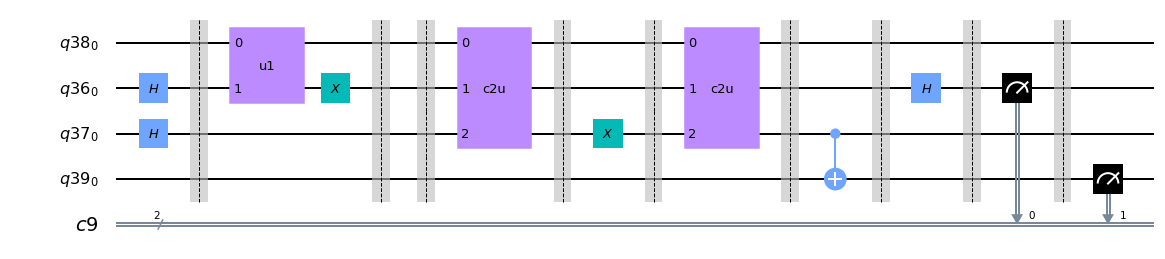

In [3]:
c.draw(output = 'mpl')